<a id="tercero"></a>
## 3. Clasificación. 

Para esta última parte de la tarea, utilizaremos un conjunto de datos de mediciones al corazón en pacientes con o sin cierta condicion cardiaca. El _dataset_ puede descargarse desde https://www.kaggle.com/shayanfazeli/heartbeat#ptbdb_abnormal.csv, utilizaremos en particular los archivos `ptbdb_normal.csv` y `ptbdb_abnormal.csv`. Nuestro objetivo principal será predecir a partir de las mediciones si un paciente tiene o no tiene la condición. Sin embargo también exploraremos técnicas de reducción de dimensionalidad para tratar de preprocesar los datos, pues una rápida exploración de los datos nos muestra que tenemos 188 atributos. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style()
%matplotlib inline

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

#### 3.a Carga de datos
Cargue los datos, cree la columna `target` y junte ambos DataFrame en uno solo con método `append`. Por que es necesario pasar una lista de id al cargar los datos?

Explore rápidamente los datos: estan muy desbalanceadas las clases? Que tan dispares son las magnitudes de las mediciones? Pareciera necesario estandarizar los datos antes de utilizarlos? 

Separe los datos utilizando `train_test_split`. Qué habria ocurrido por la forma en que se cargaron los datos si utilizamos la opción `shuffle = False`? 

In [2]:
data_normal = pd.read_csv("ptbdb_normal.csv",names=[i for i in range(188)],header=None)
data_abnormal = pd.read_csv("ptbdb_abnormal.csv",names=[i for i in range(188)],header=None)
data_normal['target'] = 0
data_abnormal['target'] = 1
data = data_normal.append(data_abnormal,ignore_index=True)
np.unique(data['target'],return_counts=True)
data_pre = data.drop(columns=[184,185,186,187]) # Mas adelante piden que eliminemos estas columnas 
data_pre_train, data_pre_val = train_test_split(data_pre, test_size= 0.25)

In [3]:
np.unique(data['target'],return_counts=True)

(array([0, 1]), array([ 4046, 10506]))

In [4]:
print('Valor Maximo en el dataset {}\nValor Minimo en el dataset {}'.format(
        data.max().max(),data.min().min()))

Valor Maximo en el dataset 1.0
Valor Minimo en el dataset 0.0


In [5]:
x_tr = data_pre_train.drop(columns=['target'])
y_tr = data_pre_train['target']

x_val = data_pre_val.drop(columns=['target'])
y_val = data_pre_val['target']

### R:

El desbalanceo de clase que se presenta es que existe mas del doblede datos anormales (10506) que datos normales (4046). Esto puede presentar problemas en algunos algoritmos que tienden a sesgar hacia la clase mayoritaria.

Si bien los datos necesitarian escalarse para poder centrar los datos, en este caso no se opto debido a que todos los datos en el dataset estan entre 0 y 1.

#### 3.b Correlación
Calcule la matriz de correlación, note que esto esta implementado en pandas. Representela de alguna forma que le parezca adecuada, por ejemplo como un _heatmap_. 
Qué observa, comente.  Elimine las columnas que muestra el código. 

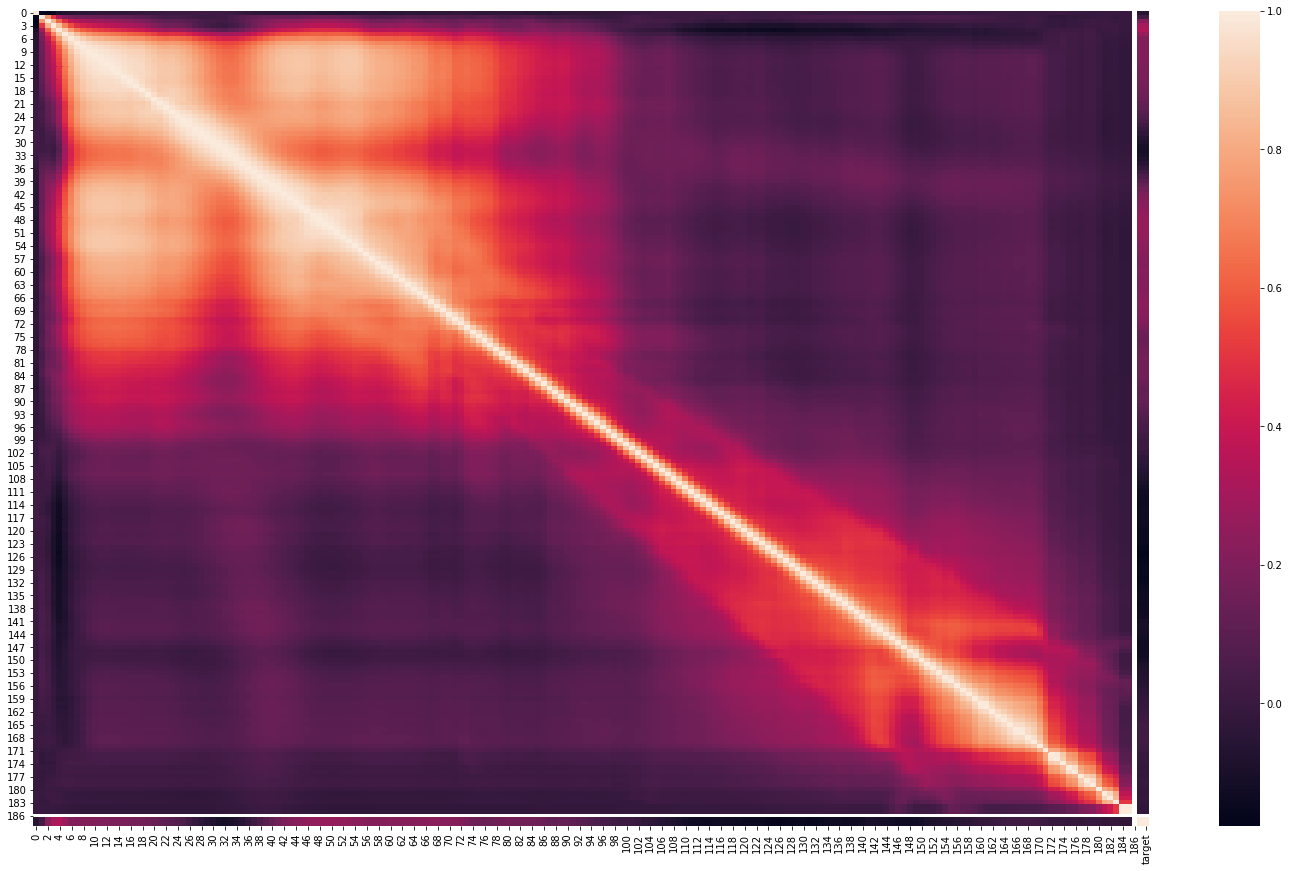

In [6]:
plt.figure(figsize=(25,15))
sns.heatmap(data.corr())
plt.show()

### R:
previamente habiamos eliminado las columnas, pero ocupamos data sin la eliminacion para hacer la matriz de correlacion. De esto podemos datrnos cuenta que hay una variable especialmente problematica: la 186, la cual si la dejamos, nuestros modelos van a obtener un rendimiento de $R^2 = 1$. Esto puede ser debido a que 186 corresponde al target. Por otra parte, existe una alta correlacion en las variables del principio del modelo, esto debe ser al problema en el cual se hacen las mediciones cardiacas en el espacio de tiempo de cada muestra.

#### 3.c Regresión Logistica
Realice una primera regresión logística con los datos. Que valor entrega el metodo `score`?

Calcule la matriz de confusión y comente respecto al valor dado por el `score`. Comente sobre la distinta información entregrada por la matriz de confusión y su interpretación. 

train score:0.833517, validation score:0.825454


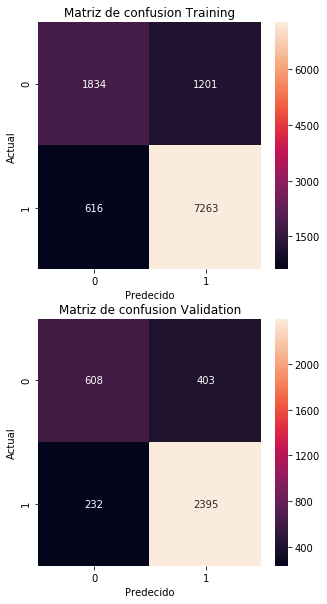

In [7]:
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression()

reg.fit(x_tr,y_tr)
train_score = reg.score(x_tr,y_tr)
val_score = reg.score(x_val,y_val)
#test_score = reg.score(x_test,y_test)

tr_predict = reg.predict(x_tr)
val_predict = reg.predict(x_val)
#test_predict = reg.predict(x_test)

print("train score:{:.6f}, validation score:{:.6f}".format(train_score,val_score))

from sklearn import metrics

confusion_matrix_tr = metrics.confusion_matrix(y_tr, tr_predict)
confusion_matrix_val = metrics.confusion_matrix(y_val, val_predict)

fig,ax = plt.subplots(2,1,figsize=(5,10))

sns.heatmap(confusion_matrix_tr,annot=True,fmt="d",ax=ax[0])
sns.heatmap(confusion_matrix_val,annot=True,fmt="d",ax=ax[1])

ax[0].set_title('Matriz de confusion Training')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predecido')

ax[1].set_title('Matriz de confusion Validation')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predecido')

plt.show()

### R:

El metodo score de la regresion logistica corresponde a la exactitud (accuracy) del modelo. Este nos indica el ratio de elementos acertados independiente a que clase corresponde. 

Por otra parte, la matriz de confusion nos permite evaluar el desempeño de un modelo mediante como clasifica las muestras, podiendo detallar los verdaderos positivos y los verdaderos negativos (los aciertos en la clasificación), como sus errores (Falso positivos y Falso negativos)

Podemos ver que la regresion logistica tanto en train como en validacion presentan un buen rendimiento no mostrando el sesgo de la clase mayoritaria (si fuese asi, tendriamos una gran cantidad de errores en el cuadrante inferior izquierdo)


#### 3.d Otra métrica. 
Otra forma de comparar modelos podría ser con la siguiente métrica. Esta mide la cantidad de aciertos pero toma en cuenta algo más. Que interpretación podría darle a la métrica en el código? 

Si un modelo entrega 0.5 y otro 0.4 en esta métrica, cual es mejor? 

In [8]:
print(np.mean((np.max(reg.predict_proba(x_val),axis=1)*(reg.predict(x_val)-y_val))**2))

0.084088025467995


### R:

Esta metrica nos entrega una metrica que penaliza los errores segun con cuanta probabilidad asignaron una muestra a la clase erronea. Si un modelo entrega 0.4 deberia ser mejor que uno con 0.5

#### 3.e PCA y LDA
Transforme los datos mediante PCA a 2 dimensiones y grafique un subsampleo de alrededor de 50 - 100 datos con 50% de cada clase. Coloree cada punto correspondiente a la clase a la que pertenece. 

Realice el mismo analisis para LDA, considerando el mismo conjunto de puntos. Cual de ambos métodos le parece más apropiado?

Grafíque el centro de gravedad (promedio en cada cordenada) de cada una de las clases luego de la reducción de dimensionalidad. 

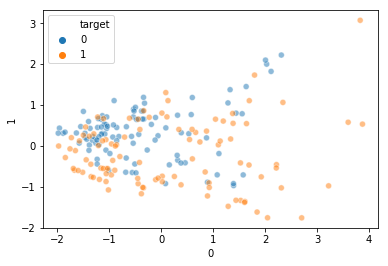

In [9]:
from sklearn import decomposition
trgts_temp = data.target
pca1 = decomposition.PCA(n_components=2)
data_transformed = pca1.fit_transform(data.drop(columns=['target']))

data_transformed_0 = data_transformed[trgts_temp ==0]
data_transformed_1 = data_transformed[trgts_temp ==1]

indices_0 = np.random.choice(data_transformed_0.shape[0], 100, replace=False)
indices_1 = np.random.choice(data_transformed_1.shape[0], 100, replace=False)

df_0 = pd.DataFrame(data_transformed_0[indices_0])
df_0['target'] = 0
df_1 = pd.DataFrame(data_transformed_1[indices_1])
df_1['target'] = 1

temp_df = df_0.append(df_1,ignore_index=True)

sns.scatterplot(x=0,y=1,hue='target',data=temp_df,alpha=0.5)
plt.show()

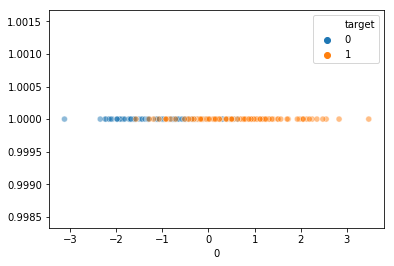

In [10]:
X = data.drop(columns=['target']).values
y = data.target.values
from sklearn import discriminant_analysis 
lda = discriminant_analysis.LinearDiscriminantAnalysis(solver='svd',n_components=2)

lda.fit(X,y)
data_transformed = lda.transform(X)

data_transformed_0 = data_transformed[y == 0]
data_transformed_1 = data_transformed[y == 1]

indices_0 = np.random.choice(data_transformed_0.shape[0], 100, replace=False)
indices_1 = np.random.choice(data_transformed_1.shape[0], 100, replace=False)

df_0 = pd.DataFrame(data_transformed_0[indices_0])
df_0['target'] = 0
df_1 = pd.DataFrame(data_transformed_1[indices_1])
df_1['target'] = 1

temp_df = df_0.append(df_1,ignore_index=True)

sns.scatterplot(x=0,y=1,hue='target',data=temp_df,alpha=0.5)
plt.show()

### R:

El metodo mas apropiado a mi paracer corresponde a PCA, debido a que LDA solo puede darnos $k-1$ dimensiones de reduccion donde $k$ es la cantidad de clases del problema. Como es un problema binario, LDA solo va a dar $1$ dimension. Esto significa que perdemos mucha información en el proceso de reduccion de dimensionalidad. 

#### 3.f Más reducción de dimensionalidad
Entrene un modelo de regresión logística para el método que le pareció más apropiado de la pregunta aterior, haciendo variar el numero de componentes de 2 a 120. Calcule para cada modelo alguna métrica de la calidad del modelo tanto sobre el conjunto de entrenamiento como sobre el conjunto de validación. 

Grafíque como varían ambos errores en función de la dimensionalidad sobre la que se trabaja. 

Si le sobra *tiempo* y _c r e a t i v i d a d_  proponga cambios o extienda la exploración buscando mejorar el desempeño o comprender mejor el problema (solo para puntaje extra).

[//](https://meme.xyz/uploads/posts/t/l-27712-i-procrastinate-to-the-last-minute-den-i-freaked-it.jpg)

In [11]:
%%time
results = []
for i in range(2,121):
    reg = LogisticRegression(solver='liblinear')
    pcai = decomposition.PCA(n_components=i)
    pcai.fit(x_tr,y_tr)
    x_tr_pca = pcai.transform(x_tr)
    x_val_pca = pcai.transform(x_val)
    reg.fit(x_tr_pca,y_tr)
    train_score = reg.score(x_tr_pca,y_tr)
    val_score = reg.score(x_val_pca,y_val)
    
    tr_predict = reg.predict(x_tr_pca)
    val_predict = reg.predict(x_val_pca)
    
    tr_mse = metrics.mean_squared_error(y_tr,tr_predict)
    val_mse = metrics.mean_squared_error(y_val,val_predict)
    
    results.append({'n_components':i,'train_mse':tr_mse,'val_mse':val_mse,
                    'train_score':train_score,'val_score':val_score})

CPU times: user 2min 22s, sys: 2.9 s, total: 2min 25s
Wall time: 27 s


In [12]:
results = pd.DataFrame(results)
results.tail()

,n_components,train_mse,train_score,val_mse,val_score
114,116,0.169782,0.830218,0.174821,0.825179
115,117,0.169141,0.830859,0.174546,0.825454
116,118,0.169782,0.830218,0.174546,0.825454
117,119,0.169415,0.830585,0.173997,0.826003
118,120,0.169599,0.830401,0.173997,0.826003


In [13]:
best_model = results.sort_values('val_score',ascending=False).iloc[0]
best_model

n_components    120.000000
train_mse         0.169599
train_score       0.830401
val_mse           0.173997
val_score         0.826003
Name: 118, dtype: float64

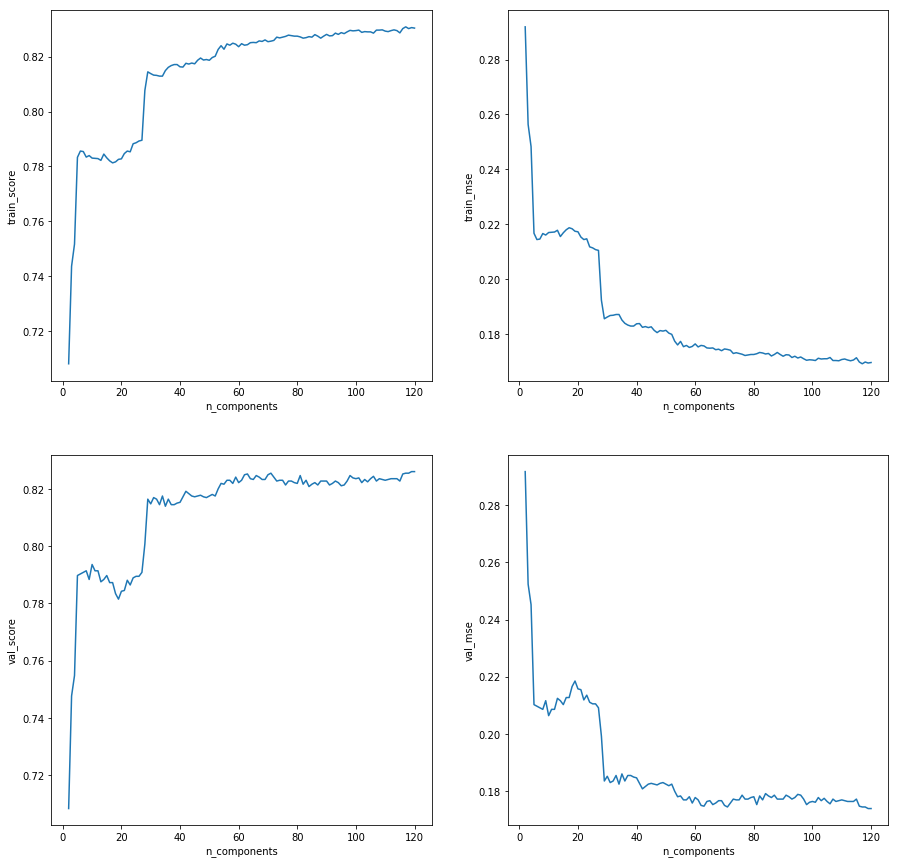

In [14]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
sns.lineplot(x='n_components',y='train_score',data=results,ax=ax[0,0])
sns.lineplot(x='n_components',y='train_mse',data=results,ax=ax[0,1])

sns.lineplot(x='n_components',y='val_score',data=results,ax=ax[1,0])
sns.lineplot(x='n_components',y='val_mse',data=results,ax=ax[1,1])

plt.show()

#### 3.g Naive Bayes
"Entrene" un modelo utilizando Naive Bayes y comparelo con el modelo logístico que entrenó anteriormente. Le parece adecuado el nombre _Naive_?

train score:0.641286, validation score:0.648158


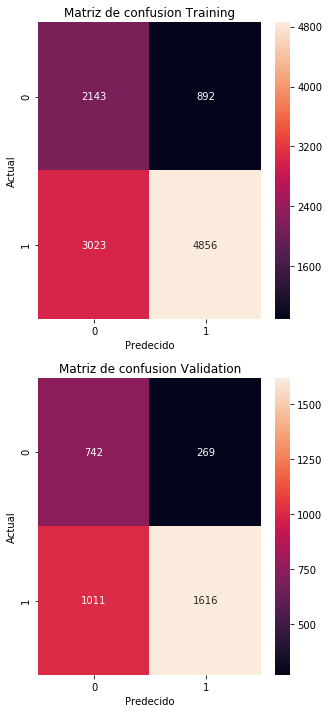

In [15]:
from sklearn import naive_bayes as sknb
NB = sknb.BernoulliNB()

NB.fit(x_tr,y_tr)
train_score = NB.score(x_tr,y_tr)
val_score = NB.score(x_val,y_val)

tr_predict = NB.predict(x_tr)
val_predict = NB.predict(x_val)

print("train score:{:.6f}, validation score:{:.6f}".format(train_score,val_score))



confusion_matrix_tr = metrics.confusion_matrix(y_tr, tr_predict)
confusion_matrix_val = metrics.confusion_matrix(y_val, val_predict)

fig,ax = plt.subplots(2,1,figsize=(5,12))

sns.heatmap(confusion_matrix_tr,annot=True,fmt="d",ax=ax[0])
sns.heatmap(confusion_matrix_val,annot=True,fmt="d",ax=ax[1])

ax[0].set_title('Matriz de confusion Training')
ax[0].set_ylabel('Actual')
ax[0].set_xlabel('Predecido')

ax[1].set_title('Matriz de confusion Validation')
ax[1].set_ylabel('Actual')
ax[1].set_xlabel('Predecido')

plt.show()
plt.show()

### R: 

El modelo de Naive bayes recibe su nombre por que asume que las variables son independientes una de otras, por lo general eso es muy pocas veces cierto en la mayoria de los problemas.
Cabe destacar que Naive bayes si bien tiene esa suposicion, por lo general se comporta bien en problemas de clasificación de texto, donde se sabe que por lo general el uso de palabras son dependientes una de otras.

En las matrices de confusion podemos observar el problema del sesgo, aparte de que el rendimiento no funciona tan bien como la regresion logistica.